In [2]:
## Collect Reddit content via public API
import json
import praw

In [3]:
# IMPORTANT: enter proper access credential in the config-file;
# make sure it is available in the same folder where this notebook is running
import config_reddit

In [4]:
# establish an API connection and verify read-only access
reddit = praw.Reddit(user_agent    = f"Content exploration by {config_reddit.app_name}",
                     client_id     = config_reddit.app_id,
                     client_secret = config_reddit.app_secret)
reddit.read_only

Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


True

In [5]:
# choose a subreddit of interest
# MODIFY this to what you prefer to analyze
#
# Example (take the string from the ending-part of the subreddit URL):
#  https://www.reddit.com/r/travel/
query_subreddit = 'travel'

In [6]:
# decide how many top-"hot" posts to query
# keep in mind data query limitations for very active subreddits
nposts = 20

In [7]:
# collect ids of the top posts within the chosen subreddit
post_ids = []
subreddit = reddit.subreddit(query_subreddit)
for p in subreddit.hot(limit = nposts):
    post_ids.append(p.id)
# check how many posts (submissions) were collected
len(post_ids)

20

In [8]:
# example post details
post_details = reddit.submission(id = post_ids[0])
print(post_details.title)
print(post_details.selftext)

All Layover Questions - READ THIS NOTICE
**READ THE NEW LAYOVER FAQ:** [**https://www.reddit.com/r/travel/wiki/mfaq-flying/layovers**](https://www.reddit.com/r/travel/wiki/mfaq-flying/layovers)

All layover questions will be removed unless your situation is unique and cannot be answered by the wiki.

**Members of the community**: please report any layover questions that can be answered by the wiki and we will remove them promptly.

Self-transfers times are not covered under this new guideline and wiki.


In [9]:
# decide how many top comments to query per post;
# NOTE: larger number of comments may dilute the content (irrelevant text)
ncomments = 10

In [10]:
# function to collect post data
def collect_post_data(post_id, ncomments, reddit):
    psubm = reddit.submission(id = post_id)
    pdata = {'id': post_id, 'title': psubm.title, 'text': psubm.selftext}
    
    # collect first- and second-level comments
    pcomm = []
    psubcomm = []
    psubm.comments.replace_more(limit = ncomments)
    for top_comment in psubm.comments:
        pcomm.append(top_comment.body)
        for lev2_comment in top_comment.replies:
            psubcomm.append(lev2_comment.body)
    
    # assemble the data together
    pdata['comments_lev1'] = pcomm
    pdata['comments_lev2'] = psubcomm
    
    return pdata

In [11]:
# collect information for each post;
# if you receive server error, try reducing the number of posts requested
posts_all = [collect_post_data(pid, ncomments, reddit) for pid in post_ids]

In [12]:
# save collected data to json file (you can inspect it in a web browser, load into pandas etc.)
file_out = f"raw_post_comment_data.json"
with open(file_out, mode='w') as f:
    f.write(json.dumps(posts_all, indent = 2))

In [19]:
import json
import pandas as pd

file_path = './raw_post_comment_data.json'
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Convert the main JSON into a DataFrame
df = pd.json_normalize(data, record_path=['comments_lev1'], meta=['id', 'title', 'text'])
df.rename(columns={0: 'comments_lev1'}, inplace=True)

# Display the table
df.head()



,comments_lev1,id,title,text
0,Hallelujah. The only thing I’d add to the FAQ ...,1dzc3zh,All Layover Questions - READ THIS NOTICE,**READ THE NEW LAYOVER FAQ:** [**https://www.r...
1,What's your favorite airport restaurant to eat...,1dzc3zh,All Layover Questions - READ THIS NOTICE,**READ THE NEW LAYOVER FAQ:** [**https://www.r...
2,Yeah but is 18 minutes long enough for me to r...,1dzc3zh,All Layover Questions - READ THIS NOTICE,**READ THE NEW LAYOVER FAQ:** [**https://www.r...
3,Take out the “*Am I due compensation?*” posts ...,1dzc3zh,All Layover Questions - READ THIS NOTICE,**READ THE NEW LAYOVER FAQ:** [**https://www.r...
4,It might be nice if this also includes what la...,1dzc3zh,All Layover Questions - READ THIS NOTICE,**READ THE NEW LAYOVER FAQ:** [**https://www.r...


In [20]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorgeluissolis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


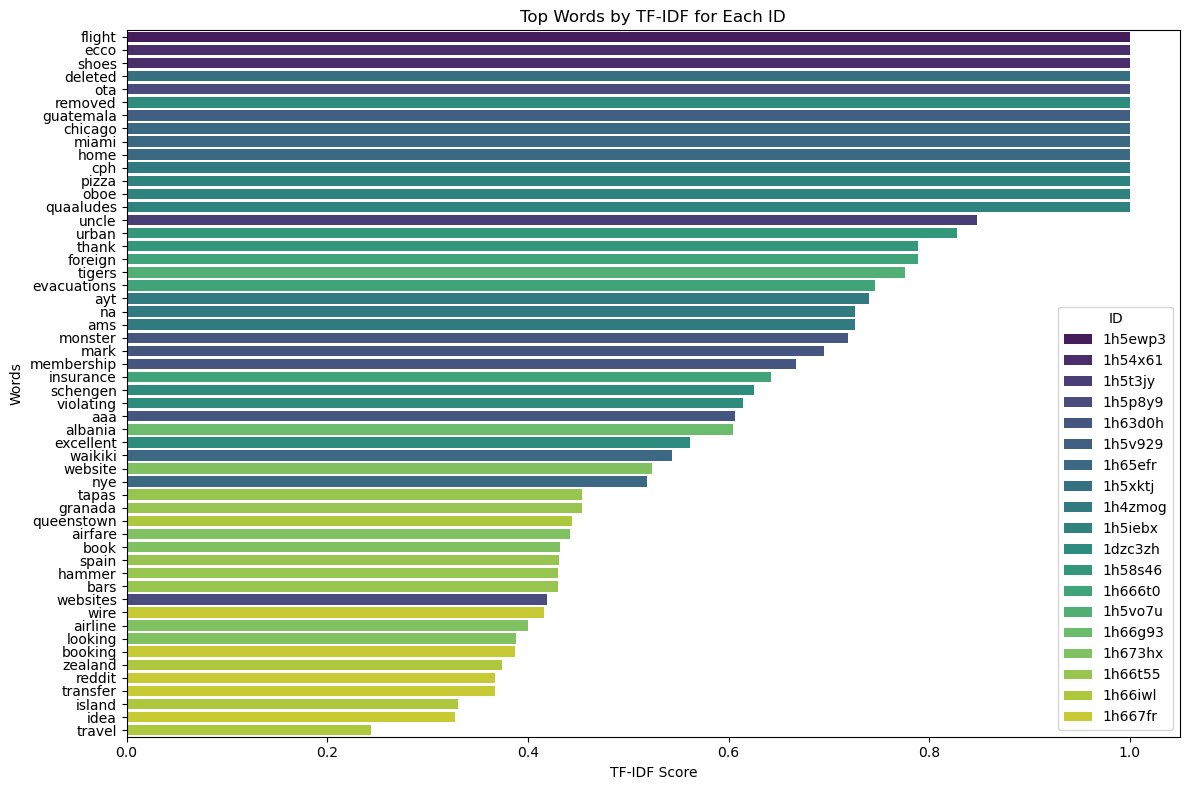

In [33]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk

# Download NLTK stopwords if not already done
nltk.download('stopwords')

# Load English stopwords and convert to a list
stop_words = list(stopwords.words('english'))

# Ensure 'comments_lev1' column has no missing values
df = df.dropna(subset=['comments_lev1'])  # Drop rows with missing comments
df['comments_lev1'] = df['comments_lev1'].str.lower()  # Convert to lowercase for consistency

# STEP 1: Tokenize and Count Words (with stopwords removed)
vectorizer = CountVectorizer(stop_words=stop_words)  # Remove stopwords during tokenization
word_counts = vectorizer.fit_transform(df['comments_lev1'])  # Create a term-document matrix
word_counts_df = pd.DataFrame(
    word_counts.toarray(), columns=vectorizer.get_feature_names_out(), index=df['id']
)

# Reshape data to replicate `count` and `group_by` behavior
word_counts_long = word_counts_df.stack().reset_index()
word_counts_long.columns = ['id', 'word', 'count']
word_counts_long = word_counts_long[word_counts_long['count'] > 0]

# Total words per 'id' (grouping by country equivalent)
total_words = word_counts_long.groupby('id')['count'].sum().reset_index()
total_words.columns = ['id', 'total']

# Merge total words into the long-form DataFrame
word_counts_long = pd.merge(word_counts_long, total_words, on='id')
word_counts_long['freq'] = word_counts_long['count'] / word_counts_long['total']

# STEP 2: Apply TF-IDF
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(word_counts)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df['id'])

# Reshape TF-IDF into long-form
tfidf_long = tfidf_df.stack().reset_index()
tfidf_long.columns = ['id', 'word', 'tf_idf']

# Combine TF-IDF scores with counts
tfidf_combined = pd.merge(word_counts_long, tfidf_long, on=['id', 'word'])

# STEP 3: Top words by TF-IDF for each ID
top_words = tfidf_combined.sort_values('tf_idf', ascending=False).groupby('id').head(5)

# STEP 4: Plot TF-IDF values
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_words, y='word', x='tf_idf', hue='id', dodge=False, palette='viridis'
)
plt.title('Top Words by TF-IDF for Each ID')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.legend(title='ID')
plt.tight_layout()  # Ensure everything fits well
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorgeluissolis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


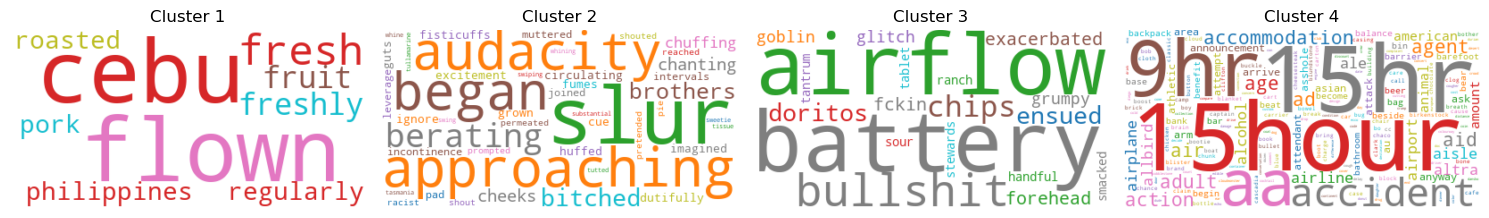

In [30]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already done
nltk.download('stopwords')

# Load the stopwords and convert to a list
stop_words = list(stopwords.words('english'))

# Step 1: Create a TF-IDF Vectorizer with stopwords removed
vectorizer = TfidfVectorizer(stop_words=stop_words)

# Step 2: Apply TF-IDF to the `comments_lev1` column
tfidf_matrix = vectorizer.fit_transform(df['comments_lev1'].dropna())

# Step 3: Calculate word similarities (Cosine Similarity)
word_sim = cosine_similarity(tfidf_matrix.T)  # Transpose for word-to-word similarity

# Step 4: Clustering words using K-Means
num_clusters = 4  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
word_clusters = kmeans.fit_predict(word_sim)

# Step 5: Map words to their clusters
words = vectorizer.get_feature_names_out()
word_cluster_df = pd.DataFrame({'word': words, 'cluster': word_clusters})

# Step 6: Generate word clouds for each cluster
plt.figure(figsize=(15, 10))  # Adjust figure size for better visibility

for cluster in range(num_clusters):
    cluster_words = word_cluster_df[word_cluster_df['cluster'] == cluster]['word']
    cluster_text = " ".join(cluster_words)
    
    wordcloud = WordCloud(background_color='white', colormap='tab10').generate(cluster_text)
    
    plt.subplot(1, num_clusters, cluster + 1)  # Create subplots for each cluster
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster + 1}')

plt.tight_layout()  # Ensure layout fits well
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorgeluissolis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/9f/z2_kx1s10h38gmr8x6sq4jb40000gn/T/ipykernel_23823/1273439100.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=idf_sorted.head(20), y='word', x='idf', palette='viridis')


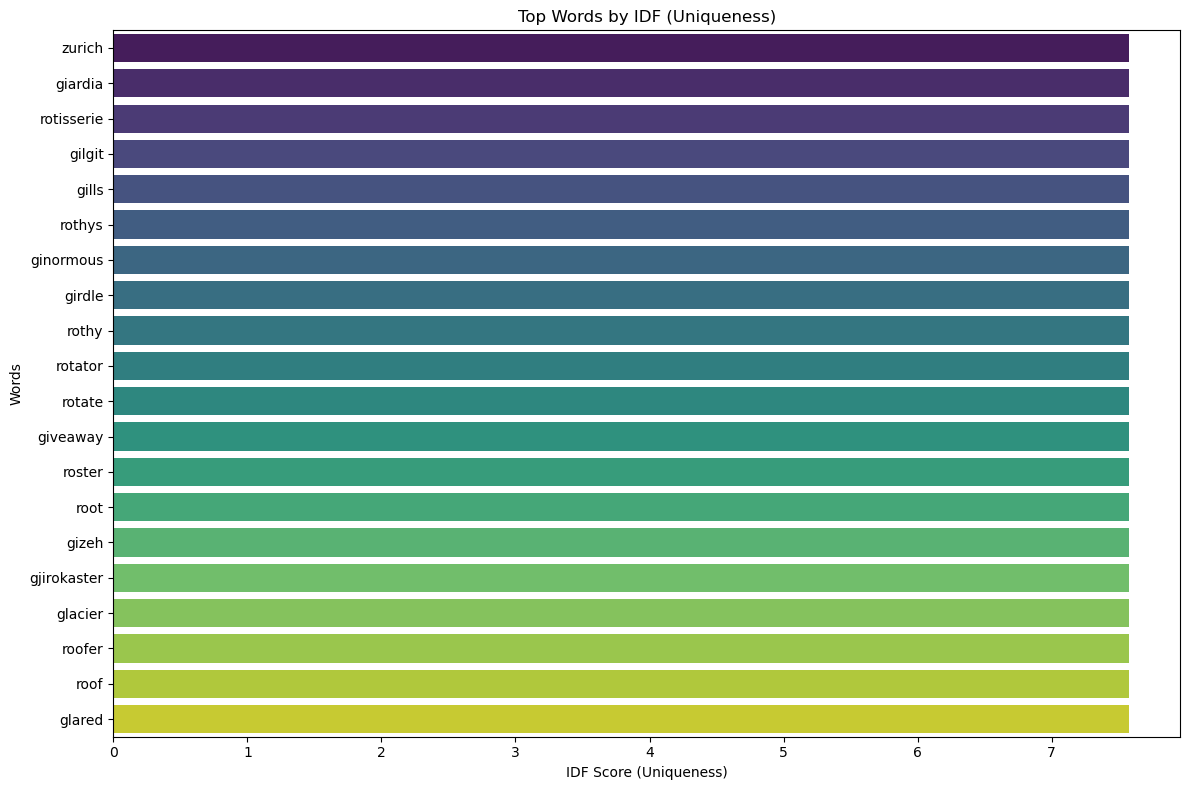

In [32]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already done
nltk.download('stopwords')

# Load English stopwords and convert to a list
stop_words = list(stopwords.words('english'))

# Ensure 'comments_lev1' column has no missing values
df = df.dropna(subset=['comments_lev1'])  # Drop rows with missing comments
df['comments_lev1'] = df['comments_lev1'].str.lower()  # Convert to lowercase for consistency

# STEP 1: Tokenize and Count Words (with stopwords removed)
vectorizer = CountVectorizer(stop_words=stop_words)  # Remove stopwords during tokenization
word_counts = vectorizer.fit_transform(df['comments_lev1'])  # Create a term-document matrix

# STEP 2: Compute IDF Values
tfidf_transformer = TfidfTransformer()  # Initialize TfidfTransformer
tfidf_transformer.fit(word_counts)  # Fit to the word counts matrix
idf_values = tfidf_transformer.idf_  # Extract IDF values

# STEP 3: Create a DataFrame with Words and IDF Values
idf_df = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'idf': idf_values})

# STEP 4: Sort Words by IDF Values
idf_sorted = idf_df.sort_values('idf', ascending=False)

# STEP 5: Visualize Top Words by IDF
plt.figure(figsize=(12, 8))
sns.barplot(data=idf_sorted.head(20), y='word', x='idf', palette='viridis')
plt.title('Top Words by IDF (Uniqueness)')
plt.xlabel('IDF Score (Uniqueness)')
plt.ylabel('Words')
plt.tight_layout()  # Ensure everything fits
plt.show()